# Computer Vision with CNN Residency-8 Project-1 - Plant Seedling Classification

Case Study Description: Plant Seedling Classification (The case study is from a dataset from Kaggle)

The case study is from a dataset from Kaggle. Link to the Kaggle project site:
https://www.kaggle.com/c/plant-seedlings-classification 

The dataset has to be downloaded from the above Kaggle web site.

Objective: Can you differentiate a weed from a crop seedling?

The ability to do so effectively can mean better crop yields and better stewardship of the environment.

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing images of approximately 960 unique plants belonging to 12 species at several growth stages.

Data Description:
The dataset comprises 12 plant species. The goal of the competition is to create a classifier capable of determining a plant's species from a photo. The list of species is as follows:
1. Black-grass
2. Charlock
3. Cleavers
4. Common Chickweed
5. Common wheat
6. Fat Hen
7. Loose Silky-bent
8. Maize
9. Scentless Mayweed
10. Shepherds Purse
11. Small-flowered Cranesbill
12. Sugar beet


Project Work:
1. Read the images and generate the train and test dataset (10 points)
2. Divide the data set into Train and validation data sets ( 10 points)
3. Initialize & build the model (20 points)
4. Optimize the model (15 points)
5. Predict the accuracy for both train and validation data (5 points)
 





In [1]:
# import all necessary packages
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import categorical_crossentropy
from keras.models import Model
from keras.models import load_model
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid

from keras.callbacks import TensorBoard
import time
import os
#from tqdm import tqdm # for progress indication

Using TensorFlow backend.


In [2]:
#np.random.seed(2017) 

### 1. Read the images and generate the train and test dataset (10 points)

In [3]:
species_list = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [4]:
data_dir = 'D:/my_learning_dataset/plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [5]:
sample_submission.head(2)

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet


In [6]:
# count image sin each species directory
for species in species_list:
    print('{}: {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))

Black-grass: 263 images
Charlock: 390 images
Cleavers: 287 images
Common Chickweed: 611 images
Common wheat: 221 images
Fat Hen: 475 images
Loose Silky-bent: 654 images
Maize: 221 images
Scentless Mayweed: 516 images
Shepherds Purse: 231 images
Small-flowered Cranesbill: 496 images
Sugar beet: 385 images


In [7]:
# prepare train dataset
train = []
for species_id, species in enumerate(species_list):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append(['train/{}/{}'.format(species, file), species_id, species])
        
train = pd.DataFrame(train, columns=['file', 'species_id', 'species'])
train.head(2)

,file,species_id,species
0,train/Black-grass/0050f38b3.png,0,Black-grass
1,train/Black-grass/0183fdf68.png,0,Black-grass


In [8]:
# find num of species class
num_species = len(np.unique(train["species_id"]))
print("num of species: ", num_species)

num of species:  12


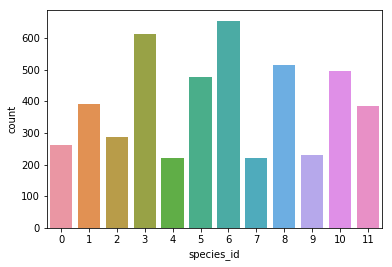

In [9]:
#plotting how the classes are distributed
sns.countplot(train["species_id"])

In [10]:
print("Training dataset shape: ",train.shape)

Training dataset shape:  (4750, 3)


In [11]:
# Training sample
#sample_per_category = 200
#train = pd.concat([train[train['species'] == c][:sample_per_category] for c in species_list])
#train = train.sample(frac=1)
#train.index = np.arange(len(train))
#print("Shape: ", train.shape)
#train.head(12)

In [12]:
# prepare test dataset
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
print("Testing dataset shape: ", test.shape)
test.head(2)

Testing dataset shape:  (794, 2)


,filepath,file
0,test/0021e90e4.png,0021e90e4.png
1,test/003d61042.png,003d61042.png


In [13]:
# fxn to read image file 
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img_data = image.img_to_array(img)
    return img_data

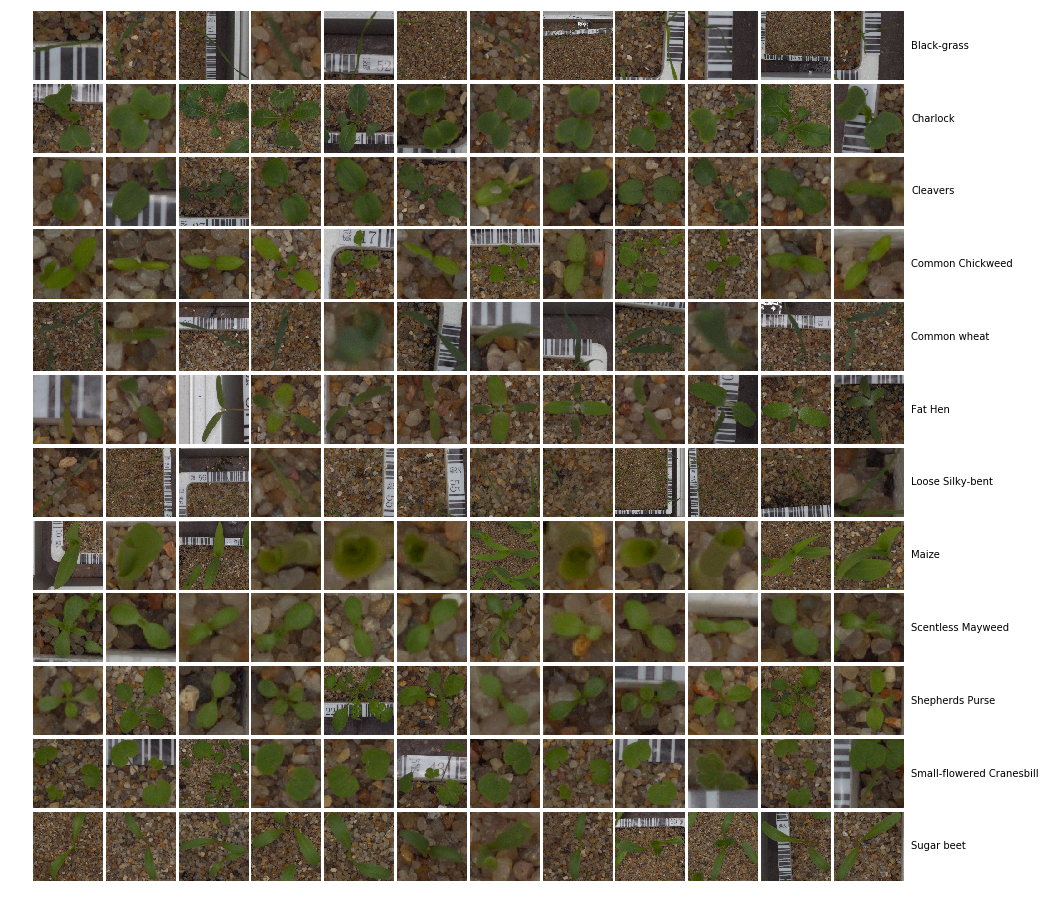

In [14]:
# have visulization of image of each classes
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(num_species, num_species), axes_pad=0.05)
i = 0
for species_id, species in enumerate(species_list):
    for filepath in train[train['species'] == species]['file'].values[:num_species]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % num_species == num_species - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [15]:
# some abbrevation for each species for later use for plotting Confusion matrix
species_abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': species_list, 'abbreviation': species_abbreviation})

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


### 2. Divide the data set into Train and validation data sets ( 10 points)

In [16]:
target = train["species_id"]

# split dataset into training and validation data with 70:30 split
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=test_size, random_state=seed)

# pls note X_train & X_test contain the records of image file.. later we will read these images
# and converted into image data(i.e pixel) for further processing

In [17]:
print("Training shape: {}".format(X_train.shape))
print("Validation shape: {}".format(X_val.shape))

Training shape: (3325, 3)
Validation shape: (1425, 3)


In [18]:
INPUT_SIZE = 32  # read image for 32x32 size

# reading image file for traing dataset
X_train_features = np.zeros((len(X_train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
#for i, file in tqdm(enumerate(X_train['file'])):
for i, file in enumerate(X_train['file']):
    img_data = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    img_data = np.expand_dims(img_data.copy(), axis=0)
    X_train_features[i] = img_data
print('Training Images shape: {} size: {:,}'.format(X_train_features.shape, X_train_features.size))

# reading image file for validation dataset
X_val_features = np.zeros((len(X_val), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in enumerate(X_val['file']):
    img_data = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    img_data = np.expand_dims(img_data.copy(), axis=0)
    X_val_features[i] = img_data
print('Validation Images shape: {} size: {:,}'.format(X_val_features.shape, X_val_features.size))

Training Images shape: (3325, 32, 32, 3) size: 10,214,400
Validation Images shape: (1425, 32, 32, 3) size: 4,377,600


In [19]:
# normalize inputs from 0-255 to 0-1
X_train_features_std = X_train_features.astype('float32')/255
X_val_features_std = X_val_features.astype('float32')/255

In [20]:
# dataset have 12 classes and each label is an integer between 0 and 11:
y_train_cat = keras.utils.to_categorical(y_train, num_classes=num_species)
y_val_cat = keras.utils.to_categorical(y_val, num_classes=num_species)

In [21]:
print(y_train_cat.shape)
print('First 5 examples are: \n', y_train_cat[0:5])

(3325, 12)
First 5 examples are: 
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [22]:
# input size
print("Training data shape:")
print("Features: ",X_train_features.shape)
print("Target: ",y_train_cat.shape)

print("\nValidation data shape:")
print("Features: ",X_val_features.shape)
print("Target: ",y_val_cat.shape)

Training data shape:
Features:  (3325, 32, 32, 3)
Target:  (3325, 12)

Validation data shape:
Features:  (1425, 32, 32, 3)
Target:  (1425, 12)


In [23]:
# input image dimensions
num_train, img_rows, img_cols, img_channels =  X_train_features.shape
input_shape = (img_rows, img_cols, img_channels)
input_shape

(32, 32, 3)

### 3. Initialize & build the model (20 points)

In [102]:
# utility fxn to plot model history and accuracy for each epoch
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
# utiliy fxn to get y_predict in 1D
# y_predict is array of 12 classes for each cases.. let form the new data which give label value in 1D.. 
# this is required for classification matrix.. cm expect 1D array
def get1D_y_predict(y_pred):
    result = []
    for i in range(len(y_pred)):
        result.append(np.where(y_pred[i] == np.max(y_pred[i]))[0][0])
    return result    
    
def plot_cnf_matrix(cnf_matrix, name):
    fig, ax = plt.subplots(1, figsize=(12,5))
    ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
    ax.set_xticklabels(species_abbreviation)
    ax.set_yticklabels(species_abbreviation)
    plt.title('Confusion Matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    fig.savefig('cnf/{}.png'.format(name), dpi=300)
    plt.show();

In [115]:
# Define the model
def create_model(stride):
    model = Sequential()

    # padding = 'same' return the output having same dimension as inout image
    model.add(Conv2D(48, kernel_size=(stride, stride), padding='same', activation='relu', input_shape=input_shape, name='layer1_conv1'))
    model.add(Conv2D(48, kernel_size=(stride, stride), activation='relu', name='layer1_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='layer1_pool'))
    model.add(Dropout(rate=0.25, name='layer1_dropout'))

    model.add(Conv2D(96, kernel_size=(stride, stride), padding='same', activation='relu', name='layer2_conv1'))
    model.add(Conv2D(96, kernel_size=(stride, stride), activation='relu', name='layer2_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='layer2_pool'))
    model.add(Dropout(rate=0.25, name='layer2_dropout'))

    #Flatten the layer
    model.add(Flatten(name='flatten'))

    model.add(Dense(512, activation='relu', name='fc1'))
    model.add(Dropout(rate=0.25, name='fc1_dropout'))
    model.add(Dense(256, activation='relu', name='fc2'))
    model.add(Dropout(rate=0.25, name='fc2_dropout'))

    # output layer 12 classes (class 0 to 11) - num of species
    model.add(Dense(num_species, activation='softmax', name='species'))
    return model

**Experiment-1: Create model with learnable Covn layer, Maxpool and FC and build using SGD optimizer**

In [116]:
# Compile the model with adma optimizer 
model1 = create_model(stride=3)
model1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [117]:
# review the model
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_conv1 (Conv2D)        (None, 32, 32, 48)        1344      
_________________________________________________________________
layer1_conv2 (Conv2D)        (None, 30, 30, 48)        20784     
_________________________________________________________________
layer1_pool (MaxPooling2D)   (None, 15, 15, 48)        0         
_________________________________________________________________
layer1_dropout (Dropout)     (None, 15, 15, 48)        0         
_________________________________________________________________
layer2_conv1 (Conv2D)        (None, 15, 15, 96)        41568     
_________________________________________________________________
layer2_conv2 (Conv2D)        (None, 13, 13, 96)        83040     
_________________________________________________________________
layer2_pool (MaxPooling2D)   (None, 6, 6, 96)          0         
__________

**Initializing Early stopping and Model chekpoint callbacks**

In [118]:
# use tensorboard callback which will passed in model.fit function.
#Setting the directory to store the logs.
tensorboard = TensorBoard(log_dir=".logs/{}".format(time.time()))

#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.0001' for more than 5 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves 
# a new low value. Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [119]:
#warnings.filterwarnings('ignore')

# Train the model
start = time.time()

history1 = model1.fit(X_train_features_std, y_train_cat, # feature and target vector
          validation_data=(X_val_features_std, y_val_cat), # data for evaluation
          epochs=50,
          batch_size=64, # Number of observations per batch
          verbose=1,     # Print description after each epoch
          callbacks=[tensorboard,early_stopping,model_checkpoint])

end = time.time()
execution_dur1 = end - start;

Train on 3325 samples, validate on 1425 samples
Epoch 1/50
3325/3325 [==============================] - 19s 6ms/step - loss: 2.4582 - acc: 0.1179 - val_loss: 2.4416 - val_acc: 0.1446

Epoch 00001: val_loss improved from inf to 2.44159, saving model to cnn_checkpoint_01_loss2.4416.h5
Epoch 2/50
3325/3325 [==============================] - 17s 5ms/step - loss: 2.4266 - acc: 0.1359 - val_loss: 2.4277 - val_acc: 0.1446

Epoch 00002: val_loss improved from 2.44159 to 2.42771, saving model to cnn_checkpoint_02_loss2.4277.h5
Epoch 3/50
3325/3325 [==============================] - 17s 5ms/step - loss: 2.4212 - acc: 0.1296 - val_loss: 2.4280 - val_acc: 0.1446

Epoch 00003: val_loss did not improve from 2.42771
Epoch 4/50
3325/3325 [==============================] - 17s 5ms/step - loss: 2.4196 - acc: 0.1293 - val_loss: 2.4277 - val_acc: 0.1439

Epoch 00004: val_loss improved from 2.42771 to 2.42767, saving model to cnn_checkpoint_04_loss2.4277.h5
Epoch 5/50
3325/3325 [===========================

3325/3325 [==============================] - 17s 5ms/step - loss: 1.6665 - acc: 0.3970 - val_loss: 1.5794 - val_acc: 0.4161

Epoch 00036: val_loss improved from 1.60987 to 1.57940, saving model to cnn_checkpoint_36_loss1.5794.h5
Epoch 37/50
3325/3325 [==============================] - 16s 5ms/step - loss: 1.6048 - acc: 0.4099 - val_loss: 1.5863 - val_acc: 0.4182

Epoch 00037: val_loss did not improve from 1.57940
Epoch 38/50
3325/3325 [==============================] - 16s 5ms/step - loss: 1.6248 - acc: 0.4069 - val_loss: 1.5267 - val_acc: 0.4295

Epoch 00038: val_loss improved from 1.57940 to 1.52669, saving model to cnn_checkpoint_38_loss1.5267.h5
Epoch 39/50
3325/3325 [==============================] - 16s 5ms/step - loss: 1.5792 - acc: 0.4253 - val_loss: 1.4936 - val_acc: 0.4505

Epoch 00039: val_loss improved from 1.52669 to 1.49360, saving model to cnn_checkpoint_39_loss1.4936.h5
Epoch 40/50
3325/3325 [==============================] - 17s 5ms/step - loss: 1.5979 - acc: 0.4153 - 

In [120]:
print("Model execution time: %0.2f minutes" %(execution_dur1/60))

Model execution time: 14.70 minutes


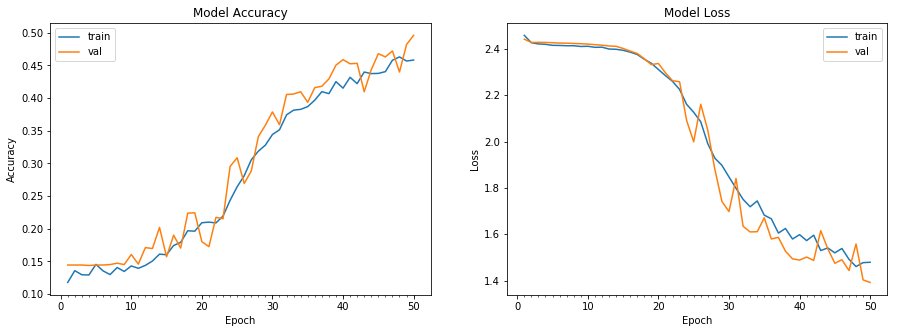

1425/1425 [==============================] - 3s 2ms/step

Validation accuracy: 49.61


In [121]:
# plot model history
plot_model_history(history1)

# compute accuracy for validation dataset
val_loss1, val_acc1 = model1.evaluate(X_val_features_std, y_val_cat)
print('\nValidation accuracy: %0.2f' %(val_acc1*100))

**Clasification report with accracy & F1 score**

In [122]:
# predict the model
y_predict1 = model1.predict(X_val_features_std)
y_predict1D_1 = get1D_y_predict(y_predict1)
acc1 = metrics.accuracy_score(y_val,y_predict1D_1)
print('Validation accuracy: %0.2f' %(acc1*100))

# classification report with model acciracy and F1 score
cr1 = metrics.classification_report(y_val,y_predict1D_1)
print("Classification Report: \n\n", cr1)

Validation accuracy: 49.61
Classification Report: 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.47      0.43      0.45       129
           2       0.80      0.04      0.08        95
           3       0.58      0.61      0.59       175
           4       0.00      0.00      0.00        64
           5       0.40      0.40      0.40       129
           6       0.60      0.92      0.72       206
           7       0.54      0.28      0.37        79
           8       0.34      0.62      0.44       139
           9       0.56      0.25      0.35        79
          10       0.62      0.85      0.72       151
          11       0.33      0.40      0.36       112

   micro avg       0.50      0.50      0.50      1425
   macro avg       0.44      0.40      0.37      1425
weighted avg       0.48      0.50      0.45      1425



C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Confusion matrix: true vs predicted**

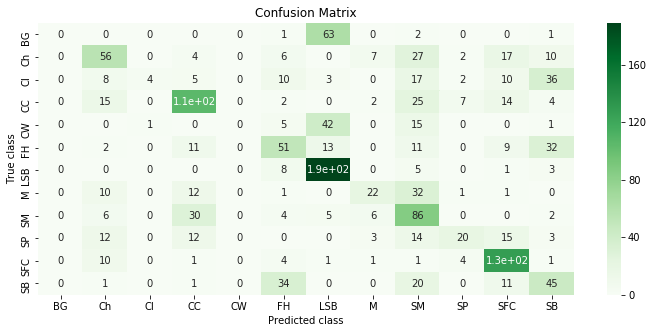

In [123]:
# confusion matrix
cm1 = metrics.confusion_matrix(y_val, y_predict1D_1)
plot_cnf_matrix(cm1,"model1_conv_fc")

In [124]:
# Save model and weights for future use. 
model1.save('models/plant_model1.h5')
model1.save_weights('models/plant_weights1.h5')

### 4. Optimize the model (15 points)

**Optimizing model: Experiment-2:**: Above base model is optimize with following experiment by using stride with small value and using adma optimizer with small learning rate. 

In [46]:
model2 = create_model(stride=2)

# Compile the model with Adam optimizer with smaller learning rate 
optimizer = keras.optimizers.Adam(lr=0.001)

model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# Train the model
start = time.time()

history2 = model2.fit(X_train_features_std, y_train_cat, # feature and target vector
          validation_data=(X_val_features_std, y_val_cat), # data for evaluation
          epochs=50,
          batch_size=64, # Number of observations per batch
          verbose=1,     # Print description after each epoch
          callbacks=[tensorboard,early_stopping,model_checkpoint])

end = time.time()
execution_dur2 = end - start;

Train on 3325 samples, validate on 1425 samples
Epoch 1/50
3325/3325 [==============================] - 14s 4ms/step - loss: 2.4216 - acc: 0.1329 - val_loss: 2.4033 - val_acc: 0.1523

Epoch 00001: val_loss improved from inf to 2.40333, saving model to cnn_checkpoint_01_loss2.4033.h5
Epoch 2/50
3325/3325 [==============================] - 13s 4ms/step - loss: 2.0195 - acc: 0.2998 - val_loss: 1.5455 - val_acc: 0.4695

Epoch 00002: val_loss improved from 2.40333 to 1.54547, saving model to cnn_checkpoint_02_loss1.5455.h5
Epoch 3/50
3325/3325 [==============================] - 13s 4ms/step - loss: 1.3725 - acc: 0.5152 - val_loss: 1.2610 - val_acc: 0.5621

Epoch 00003: val_loss improved from 1.54547 to 1.26103, saving model to cnn_checkpoint_03_loss1.2610.h5
Epoch 4/50
3325/3325 [==============================] - 13s 4ms/step - loss: 1.1643 - acc: 0.5892 - val_loss: 1.0767 - val_acc: 0.6344

Epoch 00004: val_loss improved from 1.26103 to 1.07665, saving model to cnn_checkpoint_04_loss1.0767

In [48]:
print("Model execution time: %0.2f minutes" %(execution_dur2/60))

Model execution time: 4.08 minutes


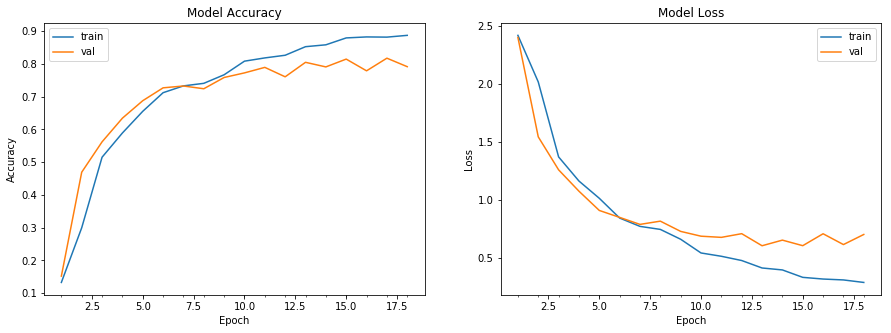

1425/1425 [==============================] - 2s 1ms/step

Validation accuracy: 79.16


In [49]:
# plot model history
plot_model_history(history2)

# compute accuracy for validation dataset
val_loss2, val_acc2 = model2.evaluate(X_val_features_std, y_val_cat)
print('\nValidation accuracy: %0.2f' %(val_acc2*100))

**Clasification report with accuracy & F1 score**

In [50]:
# predict the model
y_predict2 = model2.predict(X_val_features_std)
y_predict1D_2 = get1D_y_predict(y_predict2)
acc2 = metrics.accuracy_score(y_val,y_predict1D_2)
print('Validation accuracy: %0.2f' %(acc2*100))

# classification report with model acciracy and F1 score
cr2 = metrics.classification_report(y_val,y_predict1D_2)
print("Classification Report: \n\n", cr2)

Validation accuracy: 79.16
Classification Report: 

               precision    recall  f1-score   support

           0       0.43      0.64      0.51        67
           1       0.83      0.91      0.87       129
           2       0.70      0.93      0.80        95
           3       0.89      0.91      0.90       175
           4       0.73      0.77      0.75        64
           5       0.78      0.78      0.78       129
           6       0.89      0.65      0.75       206
           7       0.83      0.81      0.82        79
           8       0.76      0.78      0.77       139
           9       0.85      0.56      0.67        79
          10       0.86      0.88      0.87       151
          11       0.85      0.79      0.82       112

   micro avg       0.79      0.79      0.79      1425
   macro avg       0.78      0.78      0.77      1425
weighted avg       0.81      0.79      0.79      1425



**Confusion matrix: true vs predicted**

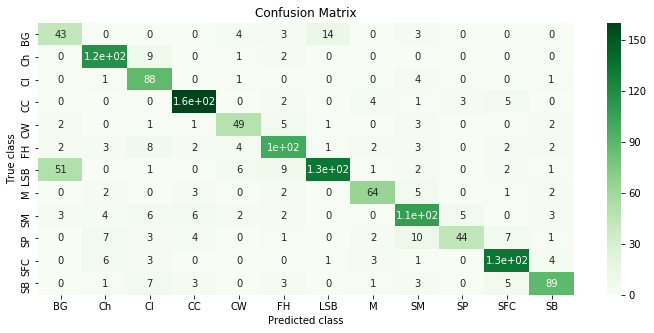

In [107]:
# confusion matrix
cm2 = metrics.confusion_matrix(y_val, y_predict1D_2)
plot_cnf_matrix(cm2,"model2_conv_fc")

In [52]:
# Save model and weights for future use. 
model2.save('models/plant_model2.h5')
model2.save_weights('models/plant_weights2.h5')

**Optimizing model: Experiment-3:**
1. Making use of transfer learning - XCEPTION
2. Using a pre-trained model in Keras to extract the common feature of a given image.
3. using the pre-trained Conv layer and adding custom dense layer on the top to build model
4. using pre-trained weight and bais from Xception model (transfer-learning)

In [54]:
import keras.applications.xception as xception

In [55]:
INPUT_SIZE = 299 # Xception need image size of 299 X 299 
POOLING = 'avg'

start = time.time()

# reading image file for traing dataset
X_train_xc = np.zeros((len(X_train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in enumerate(X_train['file']):
    img_data = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    img_data = np.expand_dims(img_data.copy(), axis=0)
    x = xception.preprocess_input(img_data)
    X_train_xc[i] = x
print('Training Images shape: {} size: {:,}'.format(X_train_xc.shape, X_train_xc.size))

# reading image file for validation dataset
X_val_xc = np.zeros((len(X_val), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in enumerate(X_val['file']):
    img_data = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    img_data = np.expand_dims(img_data.copy(), axis=0)
    x = xception.preprocess_input(img_data)
    X_val_xc[i] = x
print('Validation Images shape: {} size: {:,}'.format(X_val_xc.shape, X_val_xc.size))

end = time.time()
xc_preprocession_dur = end - start;
print("Xception preprocession execution time: %0.2f minutes" %(xc_preprocession_dur/60))

Training Images shape: (3325, 299, 299, 3) size: 891,774,975
Validation Images shape: (1425, 299, 299, 3) size: 382,189,275
Xception preprocession execution time: 2.00 minutes


In [56]:
POOLING = 'avg'

In [58]:
start = time.time()
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(X_train_xc, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(X_val_xc, batch_size=32, verbose=1)
end = time.time()
xc_predict_dur = end - start;
print("Xception predict execution time: %0.2f minutes" %(xc_predict_dur/60))

print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

1425/1425 [==============================] - 683s 479ms/step
Xception predict execution time: 38.39 minutes
Xception train bottleneck features shape: (3325, 2048) size: 6,809,600
Xception valid bottleneck features shape: (1425, 2048) size: 2,918,400


In [59]:
xc_processing_dur = xc_preprocession_dur + xc_predict_dur
print("Xception total data processing execution time: %0.2f minutes" %(xc_processing_dur/60))

Xception total data processing execution time: 40.38 minutes


In [62]:
# top layer model with dense layer
model3 = Sequential()

#input_dim is required for the first hidden layer, as it is the first starting point. --> number of inputs.
model3.add(keras.layers.BatchNormalization(input_shape=(train_x_bf.shape[1],)))

model3.add(Dense(512, activation='relu', name='fc1'))
model3.add(Dropout(rate=0.3, name='fc1_dropout'))
model3.add(Dense(256, activation='relu', name='fc2'))
model3.add(Dropout(rate=0.3, name='fc2_dropout'))
model3.add(Dense(256, activation='relu', name='fc3'))
model3.add(Dropout(rate=0.3, name='fc3_dropout'))
model3.add(Dense(128, activation='relu', name='fc4'))
model3.add(Dropout(rate=0.3, name='fc4_dropout'))

# output layer 12 classes (class 0 to 11) - num of species
model3.add(Dense(num_species, activation='softmax', name='species'))

In [63]:
# Compile the model with Adam optimizer with smaller learning rate 
optimizer = keras.optimizers.Adam(lr=0.001)

model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
# Train the model
start = time.time()

history3 = model3.fit(train_x_bf, y_train_cat, # feature and target vector
          validation_data=(valid_x_bf, y_val_cat), # data for evaluation
          epochs=50,
          batch_size=64, # Number of observations per batch
          verbose=1,     # Print description after each epoch
          callbacks=[tensorboard,early_stopping,model_checkpoint])

end = time.time()
execution_dur3 = end - start;

Train on 3325 samples, validate on 1425 samples
Epoch 1/50
3325/3325 [==============================] - 4s 1ms/step - loss: 1.9734 - acc: 0.3555 - val_loss: 1.1042 - val_acc: 0.6365

Epoch 00001: val_loss improved from inf to 1.10418, saving model to cnn_checkpoint_01_loss1.1042.h5
Epoch 2/50
3325/3325 [==============================] - 2s 559us/step - loss: 1.1580 - acc: 0.6027 - val_loss: 0.7345 - val_acc: 0.7460

Epoch 00002: val_loss improved from 1.10418 to 0.73454, saving model to cnn_checkpoint_02_loss0.7345.h5
Epoch 3/50
3325/3325 [==============================] - 2s 553us/step - loss: 0.8540 - acc: 0.7128 - val_loss: 0.6102 - val_acc: 0.7979

Epoch 00003: val_loss improved from 0.73454 to 0.61024, saving model to cnn_checkpoint_03_loss0.6102.h5
Epoch 4/50
3325/3325 [==============================] - 2s 566us/step - loss: 0.7138 - acc: 0.7522 - val_loss: 0.6140 - val_acc: 0.7937

Epoch 00004: val_loss did not improve from 0.61024
Epoch 5/50
3325/3325 [=========================

In [65]:
print("Model execution time: %0.2f minutes" %(execution_dur3/60))

Model execution time: 0.89 minutes


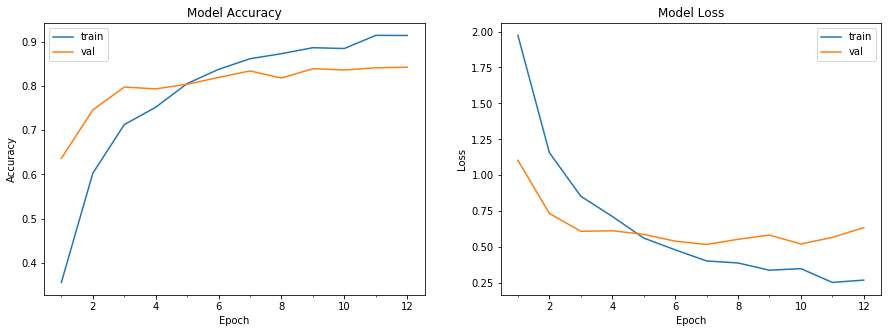

1425/1425 [==============================] - 0s 190us/step

Validation accuracy: 84.28


In [67]:
# plot model history
plot_model_history(history3)

# compute accuracy for validation dataset
val_loss3, val_acc3 = model3.evaluate(valid_x_bf, y_val_cat)
print('\nValidation accuracy: %0.2f' %(val_acc3*100))

**Clasification report with accuracy & F1 score**

In [68]:
# predict the model
y_predict3 = model3.predict(valid_x_bf)
y_predict1D_3 = get1D_y_predict(y_predict3)
acc3 = metrics.accuracy_score(y_val,y_predict1D_3)
print('Validation accuracy: %0.2f' %(acc3*100))

# classification report with model acciracy and F1 score
cr3 = metrics.classification_report(y_val,y_predict1D_3)
print("Classification Report: \n\n", cr3)

Validation accuracy: 84.28
Classification Report: 

               precision    recall  f1-score   support

           0       0.51      0.49      0.50        67
           1       0.96      0.87      0.91       129
           2       0.86      0.92      0.89        95
           3       0.78      0.85      0.81       175
           4       0.92      0.77      0.84        64
           5       0.87      0.86      0.86       129
           6       0.83      0.88      0.86       206
           7       0.95      0.94      0.94        79
           8       0.76      0.90      0.83       139
           9       0.83      0.57      0.68        79
          10       0.91      0.87      0.89       151
          11       0.92      0.91      0.91       112

   micro avg       0.84      0.84      0.84      1425
   macro avg       0.84      0.82      0.83      1425
weighted avg       0.85      0.84      0.84      1425



**Confusion matrix: true vs predicted**

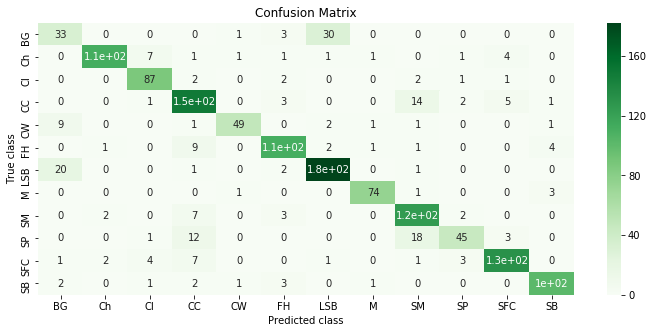

In [109]:
# confusion matrix
cm3 = metrics.confusion_matrix(y_val, y_predict1D_3)
plot_cnf_matrix(cm3,"model3_xception_fc")

In [70]:
# Save model and weights for future use. 
model3.save('models/plant_model3.h5')
model3.save_weights('models/plant_weights3.h5')

**Optimizing model: Experiment-4:**
1. Making use of transfer learning from Xception and applying there learned features on LogisticRegression

In [71]:
# LogReg on Xception bottleneck features

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=7)

start = time.time()
logreg.fit(train_x_bf, y_train)
end = time.time()
execution_dur4 = end - start;
print("Model execution time: %0.2f minutes" %(execution_dur3/60))

Model execution time: 0.89 minutes


C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [72]:
y_probs = logreg.predict_proba(valid_x_bf)

**Clasification report with accuracy & F1 score**

In [74]:
# predict the model
y_predict4 = logreg.predict(valid_x_bf)
val_acc4 = metrics.accuracy_score(y_val,y_predict4)
print('Validation accuracy: %0.2f' %(val_acc4*100))

# classification report with model acciracy and F1 score
cr4 = metrics.classification_report(y_val,y_predict4)
print("Classification Report: \n\n", cr4)

Validation accuracy: 86.67
Classification Report: 

               precision    recall  f1-score   support

           0       0.55      0.63      0.59        67
           1       0.97      0.89      0.93       129
           2       0.93      0.88      0.91        95
           3       0.84      0.90      0.87       175
           4       0.89      0.75      0.81        64
           5       0.87      0.85      0.86       129
           6       0.87      0.88      0.88       206
           7       0.96      0.95      0.96        79
           8       0.81      0.91      0.85       139
           9       0.80      0.65      0.71        79
          10       0.91      0.95      0.93       151
          11       0.94      0.91      0.92       112

   micro avg       0.87      0.87      0.87      1425
   macro avg       0.86      0.85      0.85      1425
weighted avg       0.87      0.87      0.87      1425



**Confusion matrix: true vs predicted**

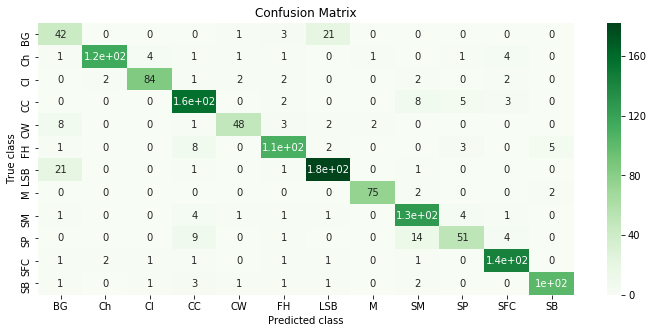

In [110]:
# confusion matrix
cm4 = metrics.confusion_matrix(y_val, y_predict4)
plot_cnf_matrix(cm4, "model4_xception_lr")

### 5. Predict the accuracy for both train and validation data (5 points)

In [77]:
# Final model - consider the better modet from above experiment.. Xception learning with Logistic Regression
final_model = logreg

In [78]:
# predict accuracy for train data
train_predict = final_model.predict(train_x_bf)
train_acc = metrics.accuracy_score(y_train,train_predict)
print('Train accuracy: %0.2f' %(train_acc*100))

Train accuracy: 99.67


In [79]:
# predict accuracy for train data
val_predict = final_model.predict(valid_x_bf)
val_acc = metrics.accuracy_score(y_val,val_predict)
print('Validation accuracy: %0.2f' %(val_acc*100))

Validation accuracy: 86.67


**Clasification report with accuracy & F1 score - for validation data**

In [80]:
# classification report with model acciracy and F1 score
cr = metrics.classification_report(y_val,val_predict)
print("Classification Report: \n\n", cr)

Classification Report: 

               precision    recall  f1-score   support

           0       0.55      0.63      0.59        67
           1       0.97      0.89      0.93       129
           2       0.93      0.88      0.91        95
           3       0.84      0.90      0.87       175
           4       0.89      0.75      0.81        64
           5       0.87      0.85      0.86       129
           6       0.87      0.88      0.88       206
           7       0.96      0.95      0.96        79
           8       0.81      0.91      0.85       139
           9       0.80      0.65      0.71        79
          10       0.91      0.95      0.93       151
          11       0.94      0.91      0.92       112

   micro avg       0.87      0.87      0.87      1425
   macro avg       0.86      0.85      0.85      1425
weighted avg       0.87      0.87      0.87      1425



**Confusion matrix for validation data: true vs predicted**

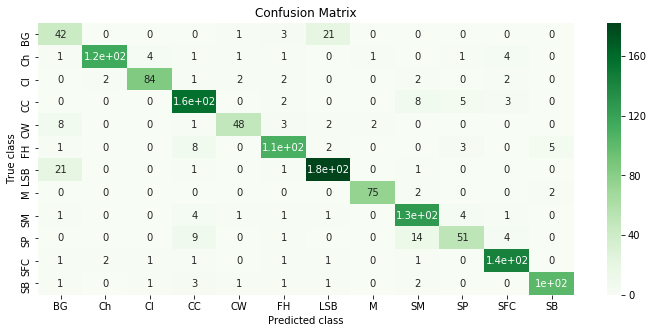

In [111]:
# confusion matrix
cm = metrics.confusion_matrix(y_val, val_predict)
plot_cnf_matrix(cm, "finalmodel_xception_lr")

### Experiment Analysis Report

**Camparing all model performance**

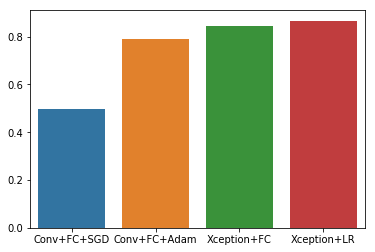

In [127]:
# comparing validation accuracy of all the experiments
models = ["Conv+FC+SGD","Conv+FC+Adam", "Xception+FC", "Xception+LR"]
model_acc = [val_acc1, val_acc2, val_acc3, val_acc4]
sns.barplot(x=models, y=model_acc)

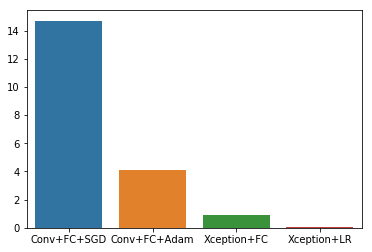

In [128]:
# comparing excution time taken in minutes to build the model for all the experiments
model_exec_durs = [execution_dur1/60, execution_dur2/60, execution_dur3/60, execution_dur4/60]
sns.barplot(x=models, y=model_exec_durs)

**Experiment-1:**: CNN with FC neural network model is built to classify the sepies. Two Conv layer with maxpool and droupout and two dense layer with SGD optimizer
1. First Epoch: train loss: 2.4582 - train acc: 0.1179 - val_loss: 2.4416 - val_acc: 0.1446
2. Went upto 50 Epochs
3. Model struggel to learn during first 10 epoch and therafter learning was quite slow and not much convergence rate 
4. Model execution time: 14.70 minutes: it trained all the layer and update weight for each iterations
5. Validation accuracy: 49.61%
6. Train loss: 1.4788 - train acc: 0.4583 - val_loss: 1.3917 - val_acc: 0.4961

**Experiment-2:**: Base model is optimized further using small stride of 2X2 and using adma optimizer with small learning rate of 0.0001.
1. First Epoc: train loss: 2.4216 - train acc: 0.1329 - val_loss: 2.4033 - val_acc: 0.1523
2. Went upto 18 Epochs beyond which validation loss does not improve further by 0.001 difference
3. Model stopped learning beyond 13 epoch 
4. Model execution time: 4.08  minutes: it trained all the layer and update weight for each iterations
5. Validation accuracy: 79.16%
6. Train loss: 0.2890 - train acc: 0.8872 - val_loss: 0.7031 - val_acc: 0.7916


**Experiment-3:**: Transfer learning is used where pre-trained weights of Xception learning are used for bottom layer and integrated with own fully connected layer.
1. First epoch: train loss: 1.9734 - train acc: 0.3555 - val_loss: 1.1042 - val_acc: 0.6365. as we can see at first epoc only model learn well because of using previous learned weight (transfer learning).
2. Went upto 12 Epochs beyond which validation loss does not improve further by 0.001 difference
3. Model stopped learning beyond 5 epoch 
4. Model execution time 0.89 minutes. model took extremely less time for learning and able to acheive little better accuracy. this is due to using previously trained weight and making convolution layer non-trainable.
5. Validation accuracy: 84.28%. with transfer learning and further traning the new dense layer, model able to aceive better accuracy.
6. Train loss: 0.2708 - train acc: 0.9146 - val_loss: 0.6356 - val_acc: 0.8428

**Experiment-4:**: Another experiment is carried out where Transfer learning from Xception are used to extract features and then fed to Logistic Regression for learning.
1. Model execution time: 0.89 minutes
2. Validation accuracy: 86.67
3. Train accuracy: 99.67

Additionally, calssification report and confusion matrix for each are generated for comparision and precison, recall and F1 scored are observed. Model using transfer learning(Exception with Logistic regrestion ) shown better perfomance for model accuracy and F1 score and also took extremely less time for learning.

**Preparing submission - as per kaggle requirement**

In [112]:
INPUT_SIZE = 299 # Xception need image size of 299 X 299 
POOLING = 'avg'

# reading image file for validation dataset
X_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in enumerate(test['filepath']):
    img_data = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(img_data)
    X_test[i] = x
print('Test Images shape: {} size: {:,}'.format(X_test.shape, X_test.size))

Test Images shape: (794, 299, 299, 3) size: 212,953,182


In [113]:
test_x_bf = xception_bottleneck.predict(X_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = final_model.predict(test_x_bf)

794/794 [==============================] - 387s 488ms/step
Xception test bottleneck features shape: (794, 2048) size: 1,626,112


In [114]:
test['category_id'] = test_preds
test['species'] = [species_list[c] for c in test_preds]
test[['file', 'species']].to_csv('submission.csv', index=False)